<a href="https://colab.research.google.com/github/pedrohortencio/sentiment-analysis/blob/main/IMDB%20Reviews/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data:
* [Kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
* [Stanford](http://ai.stanford.edu/~amaas/data/sentiment/)

## Downloading Data and Importing Libraries

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from bs4 import BeautifulSoup
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM
from keras import preprocessing
from keras.preprocessing import sequence

max_words = 10000 
maxlen = 200  
batch_size = 64
training_samples = 45000
test_samples = 5000
embedding_dim = 100

nltk.download('stopwords')  # Downloading the stopwords
nltk.download('wordnet')
sns.set_theme()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Installing Kaggle API and downloading the dataset
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 19% 5.00M/25.7M [00:00<00:00, 49.0MB/s]
100% 25.7M/25.7M [00:00<00:00, 126MB/s] 


## Data Cleaning

In [186]:
df = pd.read_csv("/content/imdb-dataset-of-50k-movie-reviews.zip", compression='zip')
df.sample(5)

,review,sentiment
16764,I watched fantabulosa! because over the last f...,positive
46942,The makers of this fine film did a terrific jo...,positive
16024,"""Boogie Nights"" is a masterpiece it tells a gr...",positive
35434,"THE EXPERT, starring Jeff Speakman, is the def...",negative
36471,*MINOR SPOILERS*<br /><br />Need any further p...,positive


In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [187]:
df['sentiment'] = [1 if i == 'positive' else 0 for i in df['sentiment']]
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [14]:
df.isnull().sum().sort_values(ascending=False)

sentiment    0
review       0
dtype: int64

### Cleaning

In [188]:
# List of stopwords
stop = set(stopwords.words('english'))
print(stop)

{'for', 'at', 'll', 'from', 'through', 'very', 'him', 'don', 'd', 'to', 'theirs', "that'll", "couldn't", 'herself', 'once', 'own', 'didn', "hasn't", 'mustn', 'will', 'those', 'but', 'which', 'what', 'while', "needn't", 'hers', 'their', 'shouldn', 'be', 'who', 'just', "should've", 'down', 'above', "you've", 'the', 'had', 've', 'during', 'too', 'after', "it's", 'were', 'between', 'hasn', 'weren', 'each', 'we', 'it', 't', 'y', 'myself', 'how', 'under', 'he', 'did', 'her', 'ain', "aren't", 'themselves', 'me', 'in', "weren't", 'am', 'doing', "wouldn't", 'is', 'by', 'these', "shan't", 'of', 'hadn', 'o', 'whom', 'a', 'couldn', 'himself', 'needn', 're', 'having', "hadn't", 'all', 'haven', 'about', 'on', 'only', 'and', 'them', 'where', "don't", 'against', 'are', 'ourselves', 'an', 'up', 'm', 'yours', "mightn't", 'have', 'here', 'if', 'wasn', 'no', 'any', 'not', 'should', 'now', "haven't", 'isn', 'my', 'same', 'ours', 'than', 'does', 'into', 'being', 'been', 'further', 'few', 'can', "shouldn't",

In [189]:
#Removing the html strips
def denoise_text(text, remove_digits=True):

    # removes html tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # removes everything between square brackets
    text = re.sub('\[[^]]*\]', '', text)

    # keeps only lower or upper case letters
    text = re.sub('[^a-zA-Z]', ' ', text)

    # lower case the text
    text = text.lower()

    # removes stopwords (words that don't add much meaning to the sentences)
    text = text.split()     # splitting because it only workds in a word-by-word scheme
    stop = set(stopwords.words('english'))
    text = [word for word in text if not word in stop]

    # Lemmatizing the text
    #lem = WordNetLemmatizer()
    #text = [lem.lemmatize(word) for word in text]

    # merging the words again
    text = ' '.join(text)

    return text
    

#Apply function on review column
df['review'] = df['review'].apply(denoise_text)

### Tokenizing

In [190]:
texts = df['review']

# Tokenizing the texts
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)

# Saving the sequences
sequences = tokenizer.texts_to_sequences(texts)

# Padding the sequences
data = pad_sequences(sequences, maxlen=maxlen)

# Saving the labels
labels = df['sentiment'].to_numpy()

# Shuffling the data and splitting in train and test
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_test = data[training_samples: training_samples + test_samples]
y_test = labels[training_samples: training_samples + test_samples]

In [191]:
# saving the tokenizer for later use (in other notebooks)
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [73]:
x_train.shape

(30000, 300)

In [74]:
x_train

array([[   0,    0,    0, ...,  147, 2306, 1535],
       [   0,    0,    0, ...,  122, 1893, 2559],
       [   0,    0,    0, ...,  116, 3823, 2085],
       ...,
       [   0,    0,    0, ...,  223, 2966,  494],
       [   0,    0,    0, ...,  336,   70,    3],
       [   0,    0,    0, ..., 3675, 1177,    3]], dtype=int32)

In [34]:
y_train.shape

(15000,)

## Creating the model

In [199]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
#model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
#odel.add(Dense(2,activation='softmax'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [200]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 100)          1000000   
_________________________________________________________________
lstm_19 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,017,057
Trainable params: 1,017,057
Non-trainable params: 0
_________________________________________________________________


In [201]:
loss_callback = EarlyStopping(monitor='val_loss', patience=3)

In [202]:
history = model.fit(x_train, y_train,
                    epochs=25,
                    batch_size=batch_size,
                    callbacks=loss_callback,
                    validation_split = 0.2)

Epoch 1/25
563/563 [==============================] - 14s 23ms/step - loss: 0.4348 - acc: 0.7885 - val_loss: 0.2760 - val_acc: 0.8852
Epoch 2/25
563/563 [==============================] - 12s 21ms/step - loss: 0.1911 - acc: 0.9271 - val_loss: 0.2773 - val_acc: 0.8867
Epoch 3/25
563/563 [==============================] - 12s 22ms/step - loss: 0.1359 - acc: 0.9517 - val_loss: 0.3320 - val_acc: 0.8828
Epoch 4/25
563/563 [==============================] - 12s 22ms/step - loss: 0.0998 - acc: 0.9666 - val_loss: 0.3555 - val_acc: 0.8753


In [203]:
model.save_weights('IMDB-lstm-model.h5')

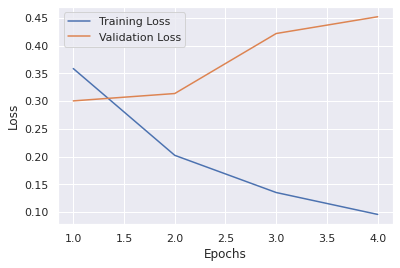

In [169]:
epochs = range(1, len(history.history['loss'])+1)   # creating a list of number from 1 to number_of_epochs
training_loss = history.history['loss']     # takes only the training loss values from the history 
validation_loss = history.history['val_loss']   # takes the validation loss values from the history


# b+ is for "blue cross"
plt.plot(epochs, training_loss, label='Training Loss')    # plots the training loss
# "bo" is for "blue dot"
plt.plot(epochs, validation_loss,label='Validation Loss')    # plots the validation loss
plt.xlabel('Epochs')    # adds X label
plt.ylabel('Loss')      # adds Y labels
plt.legend()    # adds legend

plt.show()  # display the plot

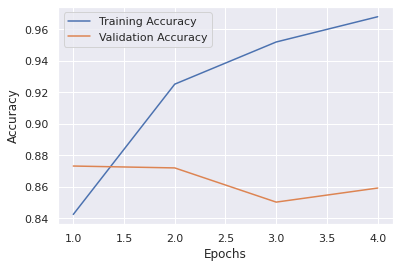

In [171]:
epochs = range(1, len(history.history['loss'])+1)
training_acc = history.history['acc']
validation_acc = history.history['val_acc']


# b+ is for "blue cross"
plt.plot(epochs, training_acc, label='Training Accuracy')
# "bo" is for "blue dot"
plt.plot(epochs, validation_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [204]:
model.evaluate(x_test, y_test)

157/157 [==============================] - 1s 6ms/step - loss: 0.3664 - acc: 0.8768


[0.3663865625858307, 0.876800000667572]

In [ ]:
# Loads the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [205]:
def predicting_reviews(texts, sequence=False):

    # Saving the sequences
    sequences = tokenizer.texts_to_sequences([texts])

    # Padding the sequences
    data = pad_sequences(sequences, maxlen=maxlen)

    return data

In [209]:
review = "I ABSOLUTELY LOVED THE MOVIE, BEST MOVIE OF ALL TIMES, GREAT PERFORMANCE"#"THIS MOVIE IS PLAINLY AWFUL. IT'S ALL THE WAY BORING AND EVEN MADE MY WIFE SLEEP"

In [210]:
#review = denoise_text(review)
review = predicting_reviews(review)

In [211]:
predict = model.predict(review)
predict

array([[0.9848695]], dtype=float32)

In [167]:
sentiment_class = round(predict[0][0])

In [165]:
if sentiment_class == 1:
    print("Positive review")
else:
    print("Negative review")

Positive review
